In [14]:
from tensorflow.python.platform import build_info as tf_build_info
tf_build_info.build_info

from platform import python_version
print(python_version())

import tensorflow as tf
print(tf.__version__)

3.8.18
2.13.0


In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [16]:
import pandas as pd
import io
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import pickle


from tqdm import tqdm
import random
%matplotlib inline

In [17]:
#curves

XRRcurve2 = np.load("curves_N.npy", allow_pickle =True)
print(XRRcurve2.shape)

q = np.linspace(0.015, 0.35, 256)

curves = XRRcurve2[:,:]*(q**4)
curves_log = np.log(curves)

print(curves_log.shape)
print("max", np.max(curves_log), "min", np.min(curves_log))
curves_n = (curves_log - np.min(curves_log))/(np.max(curves_log)-np.min(curves_log))

(1000, 256)
(1000, 256)
max -11.498660430490274 min -27.9995897309317


In [18]:
labels2 = np.load("labels_N.npy", allow_pickle =True)
labels = labels2[:,:].transpose() #RM


print(labels.shape)
print(labels[:,0])

labels_norm = np.ones([7,1000])
normalization = np.ones([7,2])

for i in range(7):
    print("max", max(labels[i,:]), "min", min(labels[i,:]))
    normalization[i,:] = max(labels[i,:]), min(labels[i,:]) 
    labels_norm[i,:] = (labels[i,:] - min(labels[i,:]))/(max(labels[i,:])-min(labels[i,:]))
labels_n = labels_norm.transpose()
labels_n = np.array(labels_n)

#np.save('normalizationSLD7.4S', normalization)

(7, 1000)
[ 5.2765 13.5512 22.7838  3.7299 13.6411  3.1639  8.3575]
max 8.4991 min 4.0044
max 14.8061 min 5.5416
max 23.4845 min 19.5086
max 4.5286 min 0.2
max 29.981 min -0.1645
max 9.9472 min 0.2
max 30.996 min -0.1514


In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv1D, Input, Activation, Concatenate, Flatten, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

In [20]:
curves_c = np.reshape(curves_n, (1000, 256,1))

curves_c = np.array(curves_c)
labels_n = np.array(labels_n)

In [21]:
def dense_block(x, growth_rate, num_layers, dropout_rate):
    for _ in range(num_layers):
        bn = layers.BatchNormalization()(x)
        relu = layers.Activation('gelu')(bn)
        conv = layers.Conv1D(growth_rate, kernel_size=5, padding='same', kernel_initializer='he_normal')(relu)
        if dropout_rate > 0:
            conv = layers.Dropout(dropout_rate)(conv)
        x = layers.Concatenate()([x, conv])
    return x

def transition_layer(x, compression_factor):
    num_channels = int(x.shape[-1] * compression_factor)
    bn = layers.BatchNormalization()(x)
    relu = layers.Activation('gelu')(bn)
    conv = layers.Conv1D(num_channels, kernel_size=1, padding='same', kernel_initializer='he_normal')(relu)
    pool = layers.MaxPooling1D(pool_size=3, strides=2)(conv)
    return pool

def dens_funnel(x,drop):
    x1 = layers.Dense(64, activation='gelu', kernel_initializer='he_normal')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(drop)(x1)
    x1 = layers.Dense(256, activation='gelu', kernel_initializer='he_normal')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(drop)(x1)
    x1 = layers.Dense(128, activation='gelu', kernel_initializer='he_normal')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(drop)(x1)
    return x1

def DenseNet_1D(input_shape, num_layers, growth_rate, compression_factor):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(3 * growth_rate, kernel_size=5, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    
    # Dense blocks
    x = dense_block(x, growth_rate, num_layers[0], dropout_rate=0.1)
    #x_all_features1 = layers.GlobalMaxPooling1D()(x)
    x_all_features1 = layers.Flatten()(x)
    x = transition_layer(x, compression_factor)
    
    x = dense_block(x, growth_rate, num_layers[1], dropout_rate=0.1)
    x_all_features2 = layers.Flatten()(x)
    x = transition_layer(x, compression_factor)

    x = dense_block(x, growth_rate, num_layers[2], dropout_rate=0.1)
    x_all_features3 = layers.Flatten()(x)
    x = transition_layer(x, compression_factor)

    x = dense_block(x, growth_rate, num_layers[3], dropout_rate=0.1)
    x_all_features4 = layers.Flatten()(x)
    x = transition_layer(x, compression_factor)
    
    x = dense_block(x, growth_rate, num_layers[4], dropout_rate=0.1)
    
    # Global pooling
    x_all_features = Flatten()(x)

    print(x_all_features1.shape, x_all_features2.shape)
    
    # Angle branch of the neural network
    x1 = layers.Dense(64, activation='gelu', kernel_initializer='he_normal')(x_all_features)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.1)(x1)
    x1 = layers.Dense(256, activation='gelu', kernel_initializer='he_normal')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0)(x1)
    
    # Another branch with reduced features
    dx1 = dens_funnel(x_all_features1, 0)

    # Another branch with reduced features
    dx2 = dens_funnel(x_all_features2, 0.2)

    # Another branch with reduced features
    dx3 = dens_funnel(x_all_features3, 0.2)

    # Another branch with reduced features
    dx4 = dens_funnel(x_all_features4, 0.2)

    # Concatenate both branches
    dxx = layers.Concatenate()([dx1,dx2])
    dxx = layers.Dense(256, activation='gelu', kernel_initializer='he_normal')(dxx)

    dyy = layers.Concatenate()([dx3,dx4])
    dyy = layers.Dense(256, activation='gelu', kernel_initializer='he_normal')(dyy)

    dx = layers.Concatenate()([dxx,dyy])
    dx = layers.Dense(512, activation='gelu', kernel_initializer='he_normal')(dx)
    dx = layers.Dense(256, activation='gelu', kernel_initializer='he_normal')(dx)

    x = layers.Concatenate()([x1, dx])
    x = layers.Dense(512, activation='gelu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.3)(x)

    # Further dense layers
    x = layers.Dense(256, activation='gelu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='gelu', kernel_initializer='he_normal')(x)
    x = layers.Dense(64, activation='gelu', kernel_initializer='he_normal')(x)
    x = layers.Dense(32, activation='gelu', kernel_initializer='he_normal')(x)
    x = layers.Dense(16, activation='gelu', kernel_initializer='he_normal')(x)
    
    # Final output layer
    outputs = layers.Dense(7, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (256, 1)
num_layers = [4, 6, 10, 6, 4]  # Dense block configuration
growth_rate = 12
compression_factor = 0.7

model = DenseNet_1D(input_shape, num_layers, growth_rate, compression_factor)
#model.summary()

(None, 21504) (None, 16510)


In [22]:
model.compile(optimizer='adam',
              loss='mean_squared_error',#mean_absolute_error
              metrics=['mean_absolute_error'])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='DensNet_N',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(curves_c[:900,:,:],
                    labels_n[:900,:],
                    epochs=5,
                    batch_size=64,
                    verbose=1,
                    validation_data = (curves_c[-100:,:,:], labels_n[-100:,:]),
                    callbacks=[model_checkpoint_callback]
                   )

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.0855 - mean_absolute_error: 0.2441INFO:tensorflow:Assets written to: DensNet_N\assets


INFO:tensorflow:Assets written to: DensNet_N\assets


15/15 [==============================] - 82s 3s/step - loss: 0.0855 - mean_absolute_error: 0.2441 - val_loss: 0.0768 - val_mean_absolute_error: 0.2369
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.0639 - mean_absolute_error: 0.2075INFO:tensorflow:Assets written to: DensNet_N\assets


INFO:tensorflow:Assets written to: DensNet_N\assets


15/15 [==============================] - 54s 4s/step - loss: 0.0639 - mean_absolute_error: 0.2075 - val_loss: 0.0752 - val_mean_absolute_error: 0.2331
Epoch 3/5
15/15 [==============================] - 24s 2s/step - loss: 0.0578 - mean_absolute_error: 0.1944 - val_loss: 0.0779 - val_mean_absolute_error: 0.2283
Epoch 4/5
15/15 [==============================] - 24s 2s/step - loss: 0.0529 - mean_absolute_error: 0.1817 - val_loss: 0.1000 - val_mean_absolute_error: 0.2497
Epoch 5/5
15/15 [==============================] - 23s 2s/step - loss: 0.0491 - mean_absolute_error: 0.1736 - val_loss: 0.1162 - val_mean_absolute_error: 0.2704


7/7 [==============================] - 4s 247ms/step
(200, 7)


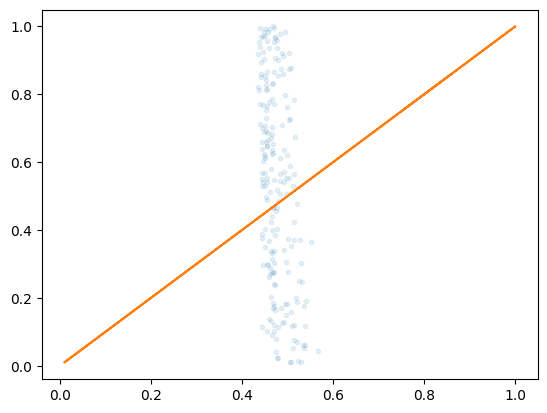

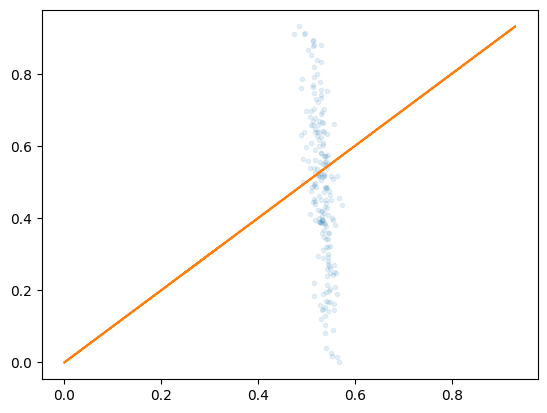

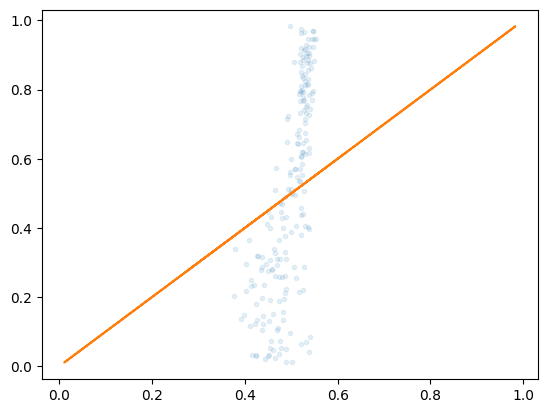

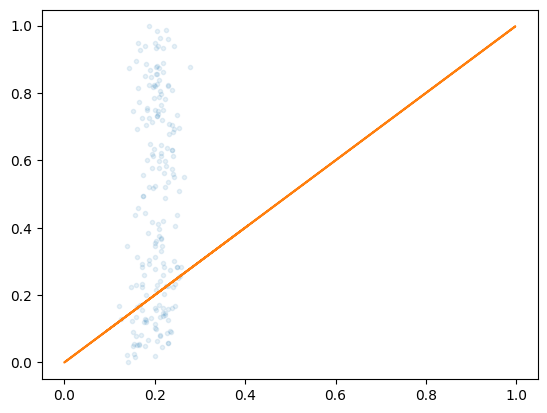

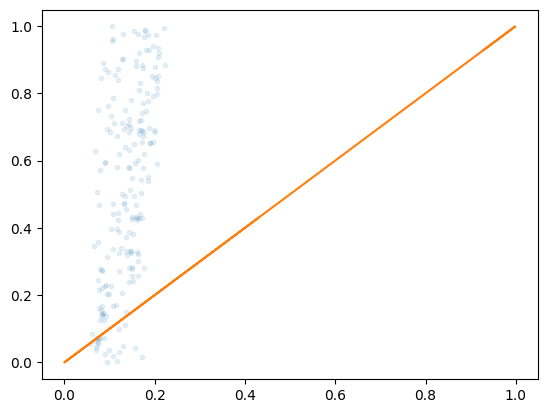

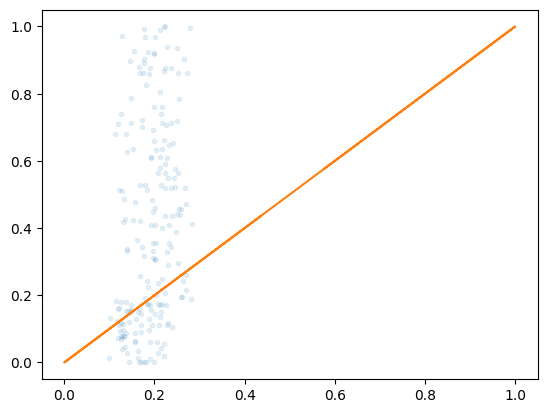

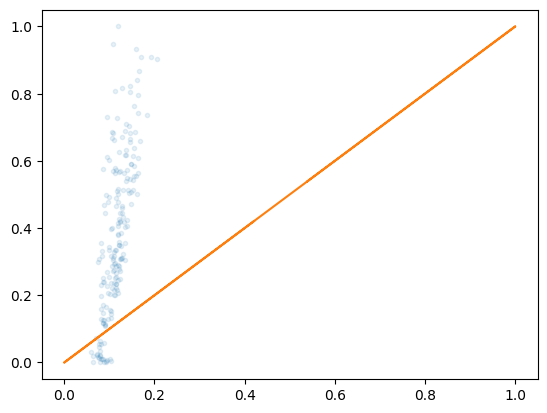

In [23]:
labels_predicted = model.predict(curves_n[-200:,:])
print(labels_predicted.shape)

for i in range(7):
    plt.plot(labels_predicted[:,i], labels_n[-200:,i],'.', alpha =0.1)
    plt.plot(labels_n[-200:,i],labels_n[-200:,i])
    plt.show()

In [24]:
model = tf.keras.models.load_model('DensNet_N')

model.compile(optimizer='adam',
              loss='mean_absolute_error',#mean_absolute_error
              metrics=['mean_squared_error'])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='DensNetNA',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(curves_c[:900,:,:],
                    labels_n[:900,:],
                    epochs=5,
                    batch_size=64,
                    verbose=1,
                    validation_data = (curves_c[-100:,:,:], labels_n[-100:,:]),
                    callbacks=[model_checkpoint_callback]
                   )

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.1911 - mean_squared_error: 0.0593INFO:tensorflow:Assets written to: DensNetNA\assets


INFO:tensorflow:Assets written to: DensNetNA\assets


15/15 [==============================] - 96s 4s/step - loss: 0.1911 - mean_squared_error: 0.0593 - val_loss: 0.2239 - val_mean_squared_error: 0.0742
Epoch 2/5
15/15 [==============================] - 31s 2s/step - loss: 0.1774 - mean_squared_error: 0.0537 - val_loss: 0.2247 - val_mean_squared_error: 0.0774
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.1666 - mean_squared_error: 0.0485INFO:tensorflow:Assets written to: DensNetNA\assets


INFO:tensorflow:Assets written to: DensNetNA\assets


15/15 [==============================] - 63s 4s/step - loss: 0.1666 - mean_squared_error: 0.0485 - val_loss: 0.2182 - val_mean_squared_error: 0.0712
Epoch 4/5
15/15 [==============================] - ETA: 0s - loss: 0.1636 - mean_squared_error: 0.0471INFO:tensorflow:Assets written to: DensNetNA\assets


INFO:tensorflow:Assets written to: DensNetNA\assets


15/15 [==============================] - 58s 4s/step - loss: 0.1636 - mean_squared_error: 0.0471 - val_loss: 0.2173 - val_mean_squared_error: 0.0690
Epoch 5/5
15/15 [==============================] - 24s 2s/step - loss: 0.1598 - mean_squared_error: 0.0454 - val_loss: 0.2321 - val_mean_squared_error: 0.0813


7/7 [==============================] - 4s 292ms/step
(200, 7)


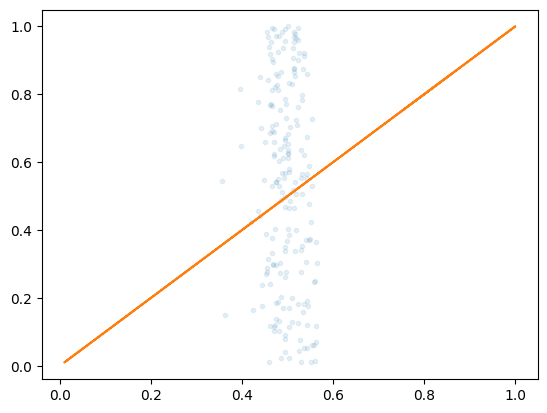

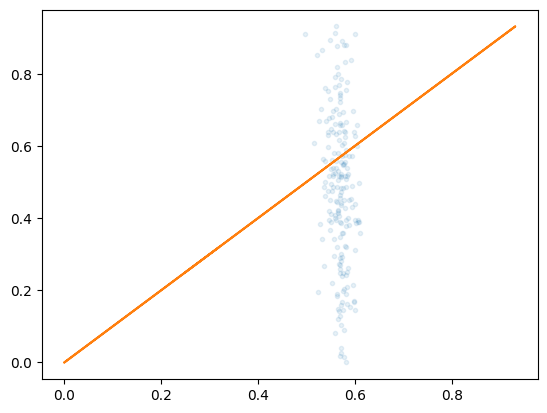

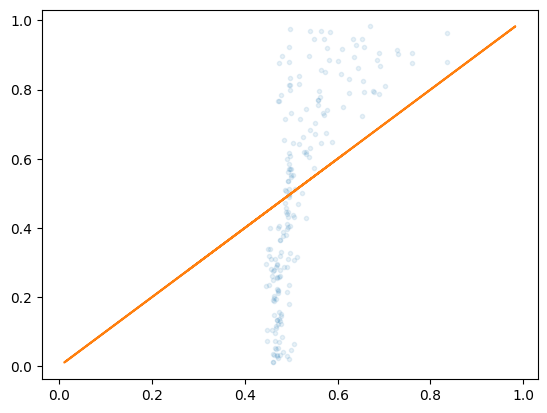

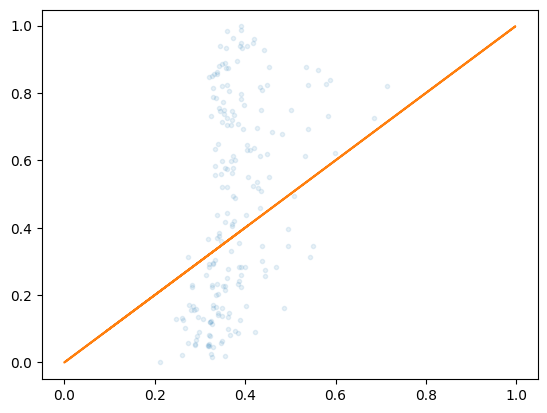

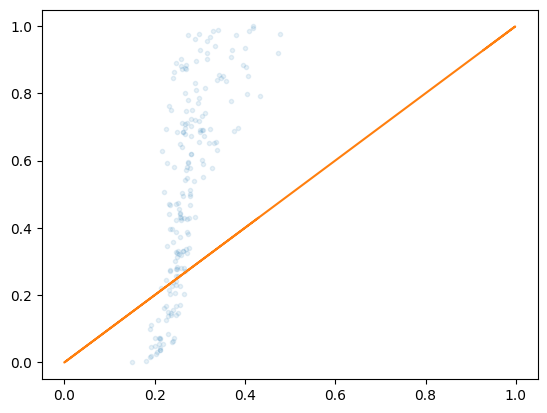

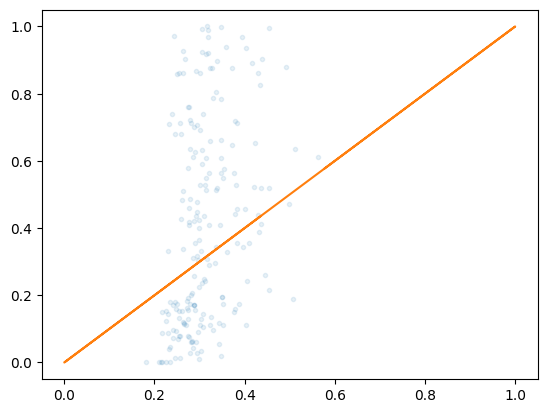

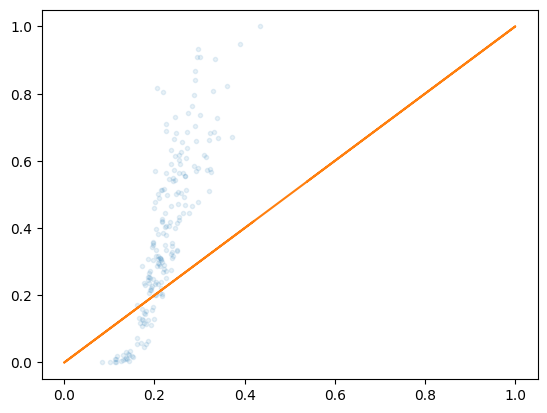

In [25]:
labels_predicted = model.predict(curves_n[-200:,:])
print(labels_predicted.shape)

for i in range(7):
    plt.plot(labels_predicted[:,i], labels_n[-200:,i],'.', alpha =0.1)
    plt.plot(labels_n[-200:,i],labels_n[-200:,i])
    plt.show()